# PageRank on Amazon Books  
**Aleksandr Dudakov**   (32312A, DSE)

This notebook computes standard and topic-sensitive PageRank scores for books based on shared reviewers.

## Setup

In [ ]:
# install
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark==3.5.1 kaggle matplotlib

# import libraries and setup environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 8g pyspark-shell" # allocate 8gb of memory to pyspark
os.environ['KAGGLE_USERNAME'] = "***" # kaggle credentials
os.environ['KAGGLE_KEY'] = "***"
import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from pyspark.sql import SparkSession, functions as F, types as T
spark = SparkSession.builder.master("local[*]").getOrCreate() # setup spark
sc = spark.sparkContext

# download dataset
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews -p book_data
!unzip -q book_data/amazon-books-reviews.zip -d book_data

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 97% 1.03G/1.06G [00:05<00:00, 192MB/s]
100% 1.06G/1.06G [00:05<00:00, 219MB/s]


## Preprocessing
Read, clean data. Build graph of books linked by reviews (>= 2 same users)

In [ ]:
# preprocessing
# read dataset
reviews = spark.read.option("header", "true").csv("book_data/Books_rating.csv") \
  .select("User_id", "Id", "Title") \
  .where(F.col("User_id").isNotNull() & F.col("Id").isNotNull())

sample = 1.0 # how much of dataset to use in final sample
if sample < 1.0:
  reviews = reviews.sample(sample, seed = 98)

print("reviews:", reviews.count())

# save titles
titles = {r["Id"]: r["Title"] for r in reviews.select("Id", "Title") \
                                      .where(F.col("Title").isNotNull()) \
                                      .dropDuplicates(["Id"]).collect()}

# build edges for books with >= 2 shared reviewers
r1 = reviews.alias("r1")
r2 = reviews.alias("r2")
edges = r1.join(r2, "User_id") \
          .where(F.col("r1.Id") < F.col("r2.Id")) \
          .groupBy(F.col("r1.Id").alias("a"), F.col("r2.Id").alias("b")) \
          .count().filter(F.col("count") >= 2).select("a", "b")

# get book ids
books = edges.selectExpr("a as id").union(edges.selectExpr("b as id")) \
             .distinct().collect()
books = sorted([row["id"] for row in books])
print("books:", len(books))

# use index for pagerank
id_to_idx = {b: i for i, b in enumerate(books)}
idx_to_id = {i: b for i, b in enumerate(books)}
idx_to_title = {i: titles.get(b, "<title unknown>") for i, b in enumerate(books)}

links = edges.rdd.flatMap(lambda row: [(id_to_idx[row.a], id_to_idx[row.b]),
                                       (id_to_idx[row.b], id_to_idx[row.a])]).collect()
pages = range(len(books))
print("pairs:", len(links)//2)

reviews: 2437750
books: 91009
pairs: 6931860


## PageRank algorithm

In [ ]:
def l2(v, q):
    return np.sqrt(((v-q)**2).sum())

def connection_matrix(pages, links):
    adjacency = {p: [] for p in pages}

    for (a, b) in links:
        adjacency[a].append(b)

    connection_matrix = []
    for a in adjacency:
       for b in adjacency[a]:
            connection_matrix.append((b, a, 1./len(adjacency[a])))

    return connection_matrix

def pagerank(pages, links, beta = 0.85, tolerance = 1e-6, max_iterations = 100,
             teleport = None):
    cm = connection_matrix(pages, links)
    links_rdd = sc.parallelize(cm).cache()

    n = len(pages)

    if teleport is None:
        teleport = np.full(n, 1/n)

    pagerank = np.ones(n)/n
    old_pagerank = np.ones(n)

    convergence_history = []
    dist = l2(pagerank, old_pagerank)
    while dist >= tolerance and len(convergence_history) < max_iterations:
        old_pagerank = pagerank
        pagerank_values = links_rdd.map(lambda t: (t[0], t[2] * pagerank[t[1]])) \
                                   .reduceByKey(lambda a, b: a+b) \
                                   .sortByKey() \
                                   .collect()

        Mv = np.array([c for i, c in pagerank_values])
        pagerank = beta*Mv + (1 - beta)*teleport
        dist = l2(pagerank, old_pagerank)
        convergence_history.append(dist)
    return pagerank / pagerank.sum(), convergence_history

## Genre extraction
Genre extraction and map id to genre

In [ ]:
# genre mapping
# read file with book info and fix genre list
genre_raw = spark.read.option("header", "true").csv("book_data/books_data.csv") \
  .select("Title", "categories") \
  .where(F.col("Title").isNotNull() & F.col("categories").isNotNull() & F.col("categories").startswith("[")) \
  .withColumn("categories_list", F.split(F.regexp_replace(F.col("categories"), "\\[|\\]|'|\"", ""), ",")) \
  .withColumn("genre", F.when(F.size("categories_list") > 0,
                              F.col("categories_list")[0]).otherwise("<genre unknown>")) \
  .select("Title", "genre").dropDuplicates(["Title"])

id_genre = reviews.select("Id", "Title").dropDuplicates(["Id"]) \
           .join(genre_raw, on = "Title", how = "left") \
           .select("Id", F.coalesce("genre", F.lit("<genre unknown>")).alias("genre")).collect()

id_to_genre = {r["Id"]: r["genre"] for r in id_genre}
idx_to_genre = {i: id_to_genre.get(idx_to_id[i], "<genre unknown>") for i in idx_to_id}

# genre counts
genre_counts = genre_raw.groupBy("genre").count().orderBy(F.desc("count")).show(10, truncate = False)

+-------------------------+-----+
|genre                    |count|
+-------------------------+-----+
|Fiction                  |20020|
|Religion                 |7923 |
|History                  |7892 |
|Juvenile Fiction         |6088 |
|Biography & Autobiography|5207 |
|Business & Economics     |4663 |
|Computers                |3659 |
|Social Science           |3212 |
|Juvenile Nonfiction      |3190 |
|Science                  |2346 |
+-------------------------+-----+
only showing top 10 rows



## Basic PageRank with taxation

iterations: 37
time: 1147.0448381900787


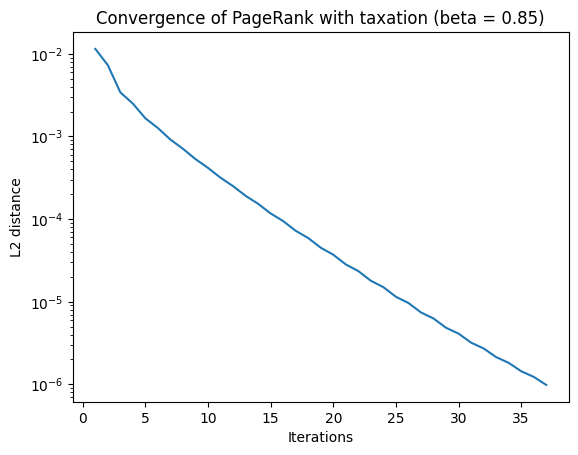

Top 20:
 1. Roy Gardner: My Story - Hellcatraz                           | Score: 1.103460e-03 | Genre: Robbers and outlaws | Id: B000IAJYQI
 2. Harry Potter and The Sorcerer's Stone                        | Score: 6.058795e-04 | Genre: Juvenile Fiction | Id: B000IEZE3G
 3. The Hobbit                                                   | Score: 5.984973e-04 | Genre: Juvenile Fiction | Id: B000NDSX6C
 4. Dune                                                         | Score: 5.460866e-04 | Genre: Art | Id: 1556909330
 5. The Two Towers                                               | Score: 5.340017e-04 | Genre: Fiction | Id: B000N28H2I
 6. The Two Towers: Part II of The Lord of the Rings (J.R.R. Tol | Score: 5.340017e-04 | Genre: Young Adult Fiction | Id: 0807209074
 7. The Two Towers                                               | Score: 5.340017e-04 | Genre: Fiction | Id: B000GY0PV4
 8. Advanced Programming in the UNIX Environment (2nd Edition)   | Score: 5.145958e-04 | Genre: Computers |

In [ ]:
# basic pagerank
t0 = time.time()
pagerank_basic, convergence_history_basic = pagerank(pages, links)
time_basic = time.time() - t0
print("iterations:", len(convergence_history_basic))
print("time:", time_basic)

plt.figure()
plt.plot(range(1, len(convergence_history_basic)+1), convergence_history_basic)
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("L2 distance")
plt.title("Convergence of PageRank with taxation (beta = 0.85)")
plt.show()

# show top 20 books
k = 20
top = np.argsort(pagerank_basic)[::-1][:k]
print("Top 20:")
for rk, idx in enumerate(top, start = 1):
    title = idx_to_title[idx][:60]
    id = idx_to_id[idx]
    genre = idx_to_genre[idx]
    score = pagerank_basic[idx]
    print(f"{rk:2}. {title:60} | Score: {score:.6e} | Genre: {genre} | Id: {id}")

## Topic-Sensitive PageRank
I focus on a specific genre (for example, Business & Economics)

chosen genre: Business & Economics
S length:  1706
iterations: 45
time: 1360.7211809158325


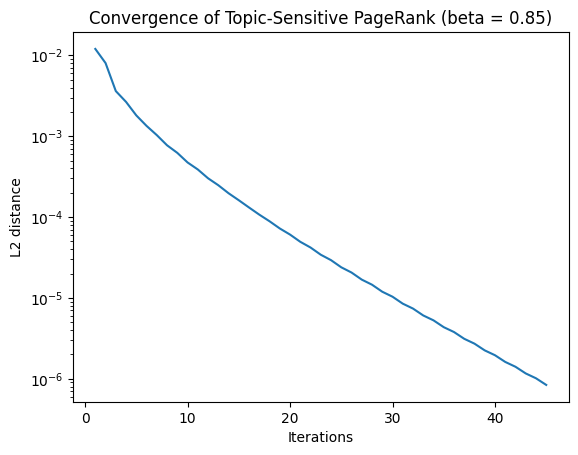

Top 20:
 1. The Tipping Point: How Little Things Can Make a Big Differen | Score: 1.741362e-03 | Genre: Reference | Id: 1587243938
 2. Rich Dad, Poor Dad                                           | Score: 1.254185e-03 | Genre: Business & Economics | Id: B000GSDG8E
 3. The Innovator's Dilemma: When New Technologies Cause Great F | Score: 1.204670e-03 | Genre: <genre unknown> | Id: B000PJVA50
 4. Before Beveridge - Welfare Before the Welfare State (Choice  | Score: 1.172160e-03 | Genre: Great Britain | Id: 0255364393
 5. Roy Gardner: My Story - Hellcatraz                           | Score: 1.138706e-03 | Genre: Robbers and outlaws | Id: B000IAJYQI
 6. Who Moved My Cheese? An-Amazing Way to Deal with Change in Y | Score: 8.974018e-04 | Genre: <genre unknown> | Id: B000ETWJ74
 7. Profitable Growth Is Everyone's Business : 10 Tools You Can  | Score: 8.704214e-04 | Genre: Business & Economics | Id: B000FUO02E
 8. Advanced Programming in the UNIX Environment (2nd Edition)   | Score: 8.666510e

In [ ]:
# topic-sensetive pagerank
chosen_genre = "Business & Economics"
print("chosen genre:", chosen_genre)

S = [idx for idx, id in idx_to_id.items() if id_to_genre.get(id) == chosen_genre]
print("S length: ", len(S))

# create teleport vector for genre
genre_teleport = None
if S:
    genre_teleport = np.zeros(len(pages))
    genre_teleport[S] = 1/len(S)

# topic pagerank
t0 = time.time()
pagerank_topic, convergence_history_topic = pagerank(pages, links, teleport = genre_teleport)
time_topic = time.time() - t0
print("iterations:", len(convergence_history_topic))
print("time:", time_topic)

plt.figure()
plt.plot(range(1, len(convergence_history_topic)+1), convergence_history_topic)
plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("L2 distance")
plt.title("Convergence of Topic-Sensitive PageRank (beta = 0.85)")
plt.show()

# show top 20 books
k = 20
top = np.argsort(pagerank_topic)[::-1][:k]
print("Top 20:")
for rk, idx in enumerate(top, start = 1):
    title = idx_to_title[idx][:60]
    id = idx_to_id[idx]
    genre = idx_to_genre[idx]
    score = pagerank_topic[idx]
    print(f"{rk:2}. {title:60} | Score: {score:.6e} | Genre: {genre} | Id: {id}")

In [ ]:
spark.stop()

## Scalability analysis

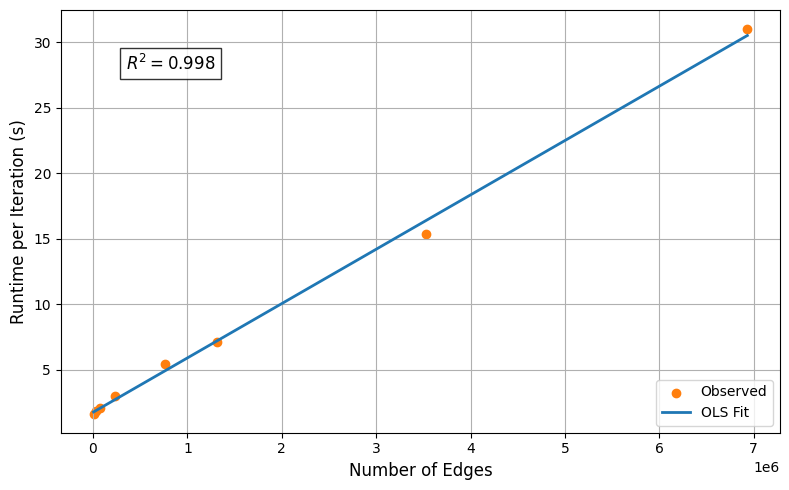

In [ ]:
# data from experiments
edges = np.array([6316, 29554, 71683, 237071, 766827, 1314828, 3526660, 6931860]).reshape(-1, 1)
iterations = np.array([64, 58, 53, 46, 41, 42, 37, 37])
times = np.array([105.64877557754517, 107.68247890472412, 110.57548666000366, 136.2843382358551, 221.68348741531372, 299.3409917354584, 567.7550237178802, 1147.0448381900787])

# runtime per iteration
times_per_iteration = times / iterations

# run OLS
model = LinearRegression()
model.fit(edges, times_per_iteration)
pred = model.predict(edges)
r2 = r2_score(times_per_iteration, pred)

#plot
plt.figure(figsize=(8,5))
plt.scatter(edges, times_per_iteration, color = 'tab:orange', label = 'Observed')
plt.plot(edges, pred, color = 'tab:blue', linewidth = 2, label = 'OLS Fit')
plt.text(
    0.05 * edges.max(),
    0.9 * times_per_iteration.max(),
    rf'$R^2 = {r2:.3f}$',
    fontsize = 12,
    bbox = dict(facecolor = 'white', alpha = 0.8))
plt.xlabel("Number of Edges", fontsize = 12)
plt.ylabel("Runtime per Iteration (s)", fontsize = 12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()